# **PLANO DE SAÚDE: ANÁLISES INICIAIS E ÁRVORE DE DECISÃO MULTINOMIAL**



### Instalação de bibliotecas

In [ ]:
# Apenas a biblioteca shap precisa ser instalada; as demais utilizadas neste notebook já vêm pré-instaladas no Google Colab
! pip install shap

### Carregamento de bibliotecas

In [5]:
from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree                                                 # Árvore de decisão
from sklearn.model_selection import train_test_split                     # Separação de conjuntos de treino e teste
from sklearn.model_selection import StratifiedKFold, cross_validate      # Validação cruzada
from sklearn.model_selection import GridSearchCV                         # Otimização de hiperparâmetros via grid search
from sklearn.model_selection import RandomizedSearchCV                   # Otimização de hiperparâmetros via random search
import shap                                                              # Interpretabilidade de modelos de ML

### Leitura da base de dados

In [6]:
dados_plano = pd.read_table("Plano_Saude.txt", sep = "\t")

In [7]:
# Reordenação de categorias da variável resposta
dados_plano['STATUS'] = pd.Categorical(dados_plano['STATUS'], categories = ['CancInvol', 'CancVol', 'Down', 'Mantem', 'Up'], ordered = True)

### Visualização da base de dados

In [8]:
display(dados_plano)

,ID_CLIENTE,NIVEL_SATISFACAO,RELACAO_CUSTO_RENDA,QTDE_UTILIZACOES_12M,TEMPO_PLANO,QTDE_SERVICOS_12M,QTDE_ATRASOS_12M,FLAG_MUDANCA_RESIDENCIA_12M,QTDE_RECLAMACOES_12M,QTDE_DEPENDENTES,IDADE,STATUS
0,CLI000001,7.7,0.11,6,4.4,3,0,Nao,0,2,78,Mantem
1,CLI000002,9.8,0.49,3,3.3,1,0,Nao,0,1,21,Mantem
2,CLI000003,6.2,0.12,4,6.4,1,0,Nao,0,0,1,Up
3,CLI000004,7.4,0.35,15,5.6,1,2,Nao,3,0,10,Mantem
4,CLI000005,0.3,0.25,26,3.5,2,2,Nao,0,1,89,Up
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,CLI099996,9.4,0.39,10,3.6,1,6,Nao,2,0,26,CancInvol
99996,CLI099997,9.2,0.25,3,6.3,2,0,Nao,1,0,42,Up
99997,CLI099998,9.6,0.09,5,8.0,2,2,Nao,1,0,23,Mantem
99998,CLI099999,5.2,0.43,2,5.9,1,0,Sim,0,0,33,Mantem


### Análise exploratória breve

In [9]:
# Medidas resumo
dados_plano.describe()

,NIVEL_SATISFACAO,RELACAO_CUSTO_RENDA,QTDE_UTILIZACOES_12M,TEMPO_PLANO,QTDE_SERVICOS_12M,QTDE_ATRASOS_12M,QTDE_RECLAMACOES_12M,QTDE_DEPENDENTES,IDADE
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000
mean,5.400644,0.276002,6.283180,4.749311,1.614490,1.441210,0.816330,0.90837,39.674740
std,3.333964,0.130661,5.502562,1.847922,1.006182,1.741779,1.132805,1.26924,18.110947
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,1.000000
25%,2.300000,0.180000,2.000000,3.300000,1.000000,0.000000,0.000000,0.00000,27.000000
50%,5.700000,0.270000,5.000000,4.700000,1.000000,1.000000,0.000000,0.00000,39.000000
75%,8.600000,0.360000,9.000000,6.200000,2.000000,2.000000,1.000000,1.00000,52.000000
max,10.000000,0.800000,46.000000,9.800000,4.000000,21.000000,13.000000,11.00000,102.000000


In [10]:
# Tabela de frequências absolutas: STATUS (variável resposta)
dados_plano['STATUS'].value_counts()

,count
STATUS,
Mantem,67000
Up,13000
Down,10000
CancInvol,6000
CancVol,4000


In [11]:
# Tabela de frequências relativas: STATUS (variável resposta)
dados_plano['STATUS'].value_counts(normalize = True).round(2)

,proportion
STATUS,
Mantem,0.67
Up,0.13
Down,0.10
CancInvol,0.06
CancVol,0.04


In [12]:
# Tabela de frequências absolutas: FLAG_MUDANCA_RESIDENCIA_12M
dados_plano['FLAG_MUDANCA_RESIDENCIA_12M'].value_counts()

,count
FLAG_MUDANCA_RESIDENCIA_12M,
Nao,95198
Sim,4802


In [13]:
# Tabela de frequências relativas: FLAG_MUDANCA_RESIDENCIA_12M
dados_plano['FLAG_MUDANCA_RESIDENCIA_12M'].value_counts(normalize = True).round(2)

,proportion
FLAG_MUDANCA_RESIDENCIA_12M,
Nao,0.95
Sim,0.05


### Análise bivariada: features vs. target

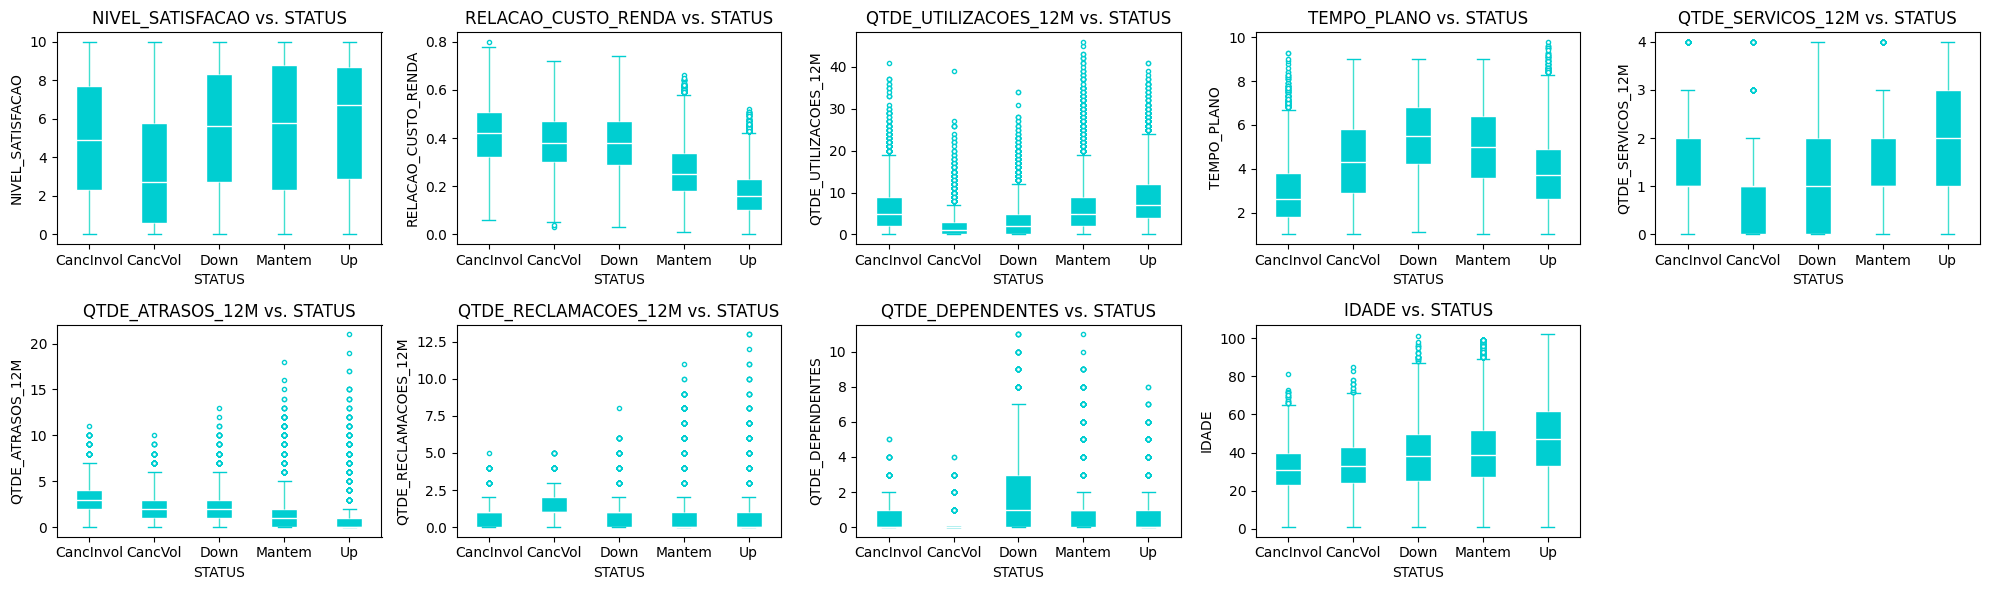

In [14]:
# Gráfico de boxplots: variáveis explicativas quantitativas versus STATUS
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (20, 6))

variaveis = ['NIVEL_SATISFACAO', 'RELACAO_CUSTO_RENDA', 'QTDE_UTILIZACOES_12M', 'TEMPO_PLANO', 'QTDE_SERVICOS_12M', 'QTDE_ATRASOS_12M', 'QTDE_RECLAMACOES_12M', 'QTDE_DEPENDENTES', 'IDADE']

for ax, variavel in zip(axes.flat, variaveis):

  sns.boxplot(y = variavel,
              x = 'STATUS',
              data = dados_plano,
              width = 0.4,
              boxprops = {'facecolor':'darkturquoise', 'edgecolor':'white'},
              whiskerprops = {'color':'turquoise'},
              capprops     = {'color': 'darkturquoise'},
              medianprops  = {'color':'white'},
              flierprops   = {'markerfacecolor': 'white', 'markeredgecolor': 'darkturquoise', 'marker': 'o', 'markersize': 3, 'color': 'turquoise', 'linestyle': 'none'},
              ax = ax)
  ax.set_title(f'{variavel} vs. STATUS')

axes.flat[-1].set_visible(False)  # Deixar vazio o 10º slot do gráfico, pois temos 9 variáveis

plt.tight_layout()
plt.show()

In [15]:
# Tabela de frequências relativas: FLAG_MUDANCA_RESIDENCIA_12M versus STATUS
pd.crosstab(dados_plano['STATUS'], dados_plano['FLAG_MUDANCA_RESIDENCIA_12M'], normalize = 'index').round(2)

FLAG_MUDANCA_RESIDENCIA_12M,Nao,Sim
STATUS,,
CancInvol,0.92,0.08
CancVol,0.76,0.24
Down,0.93,0.07
Mantem,0.98,0.02
Up,0.90,0.10


### Separação de features e target

In [16]:
X = dados_plano.drop(columns = ['STATUS', 'ID_CLIENTE'])
y = dados_plano['STATUS']

### Criação de colunas dummy para variáveis explicativas qualitativas

In [17]:
X = pd.get_dummies(X, drop_first = True)

### Modelo 1: árvore de decisão com otimização de hiperparâmetros via validação cruzada estratificada, com grid search

In [18]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'criterion': ['gini', 'entropy'],
    'min_impurity_decrease': [0.0, 0.01, 0.05, 0.1],
    'min_samples_leaf': [100, 200, 500, 1000],
    'max_depth': [2, 3, 5, 10]
}

In [19]:
# Busca da melhor combinação de hiperparâmetros, via validação cruzada estratificada com grid search, com otimização de AUC-OVR e k = 10 (EXECUÇÃO ONEROSA)
arvore = tree.DecisionTreeClassifier(class_weight = "balanced", random_state = 123)
cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 123)
scoring = {'AUC_OVR': 'roc_auc_ovr', 'balanced_accuracy': 'balanced_accuracy'}
grid_search = GridSearchCV(arvore, param_grid, cv = cv, scoring = scoring, refit = 'AUC_OVR')
grid_search.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=123),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10],
                         'min_impurity_decrease': [0.0, 0.01, 0.05, 0.1],
                         'min_samples_leaf': [100, 200, 500, 1000]},
             refit='AUC_OVR',
             scoring={'AUC_OVR': 'roc_auc_ovr',
                      'balanced_accuracy': 'balanced_accuracy'})

In [20]:
# Melhor configuração de hiperparâmetros identificada
print(grid_search.best_params_)

{'criterion': 'gini', 'max_depth': 10, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 100}


In [21]:
# Tabela de desempenho com todas as combinações de hiperparâmetros testadas, ordenadas do maior para o menor AUC-OVR médio nos conjuntos de teste
resultados_grid = pd.DataFrame(grid_search.cv_results_)
resultados_grid = resultados_grid[['params',
                                   'mean_test_AUC_OVR', 'std_test_AUC_OVR', 'rank_test_AUC_OVR',
                                   'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 'rank_test_balanced_accuracy']].sort_values(by = 'rank_test_AUC_OVR')
resultados_grid

,params,mean_test_AUC_OVR,std_test_AUC_OVR,rank_test_AUC_OVR,mean_test_balanced_accuracy,std_test_balanced_accuracy,rank_test_balanced_accuracy
48,"{'criterion': 'gini', 'max_depth': 10, 'min_im...",0.841021,0.003693,1,0.608042,0.009010,1
112,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.839200,0.003241,2,0.604888,0.006054,4
49,"{'criterion': 'gini', 'max_depth': 10, 'min_im...",0.839198,0.003592,3,0.605870,0.008358,3
113,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.838364,0.002879,4,0.606082,0.008259,2
114,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.832286,0.003096,5,0.589538,0.005618,5
...,...,...,...,...,...,...,...
31,"{'criterion': 'gini', 'max_depth': 3, 'min_imp...",0.500000,0.000000,113,0.200000,0.000000,113
46,"{'criterion': 'gini', 'max_depth': 5, 'min_imp...",0.500000,0.000000,113,0.200000,0.000000,113
45,"{'criterion': 'gini', 'max_depth': 5, 'min_imp...",0.500000,0.000000,113,0.200000,0.000000,113
15,"{'criterion': 'gini', 'max_depth': 2, 'min_imp...",0.500000,0.000000,113,0.200000,0.000000,113


In [22]:
# Modelo final a partir da melhor combinação de hiperparâmetros
arvore_1 = grid_search.best_estimator_

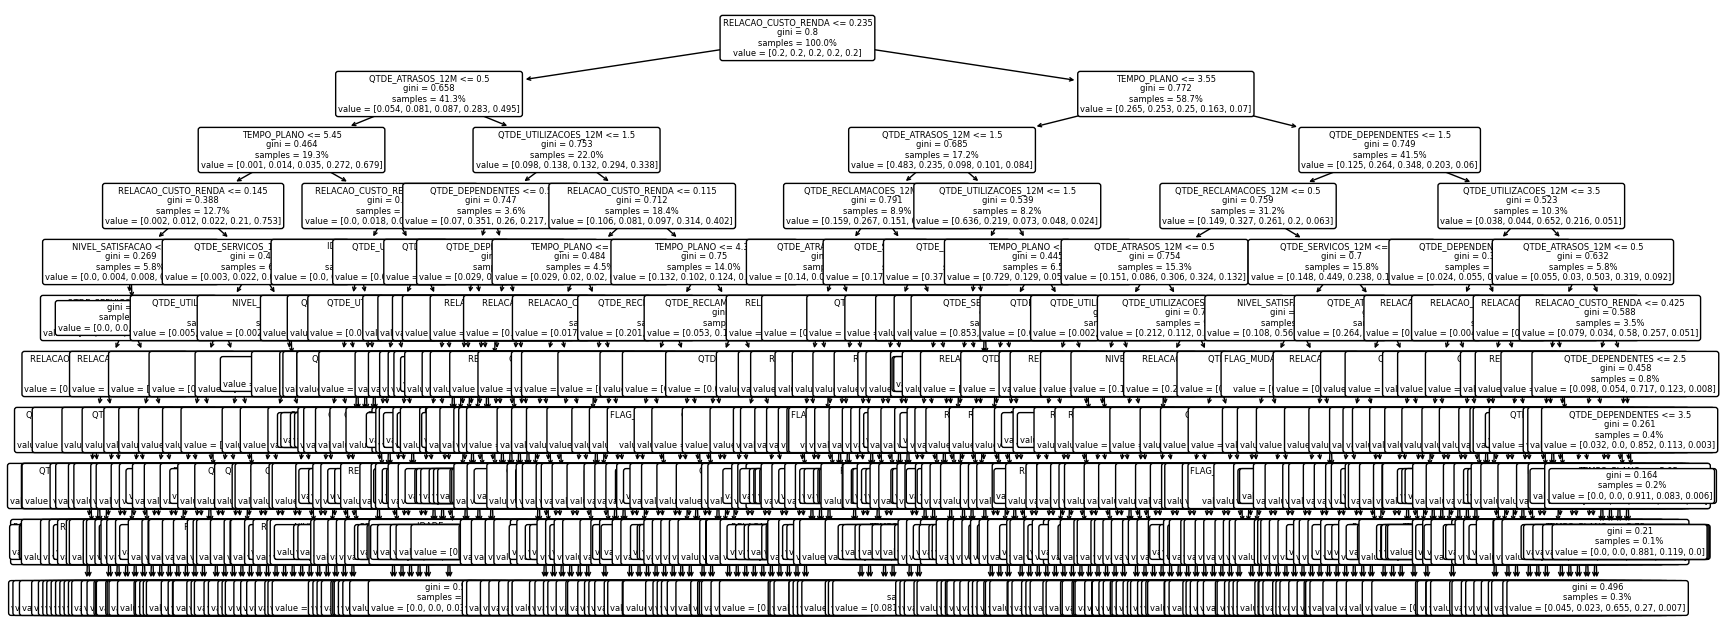

In [23]:
# Visualização da árvore de decisão correspondente ao melhor modelo (em 100% da base de dados) - VISUALMENTE INVIÁVEL
plt.figure(figsize = (20, 8))
tree.plot_tree(arvore_1,
               feature_names = X.columns,
               fontsize = 6,
               rounded = True,
               proportion = True)
plt.show()

### Modelo 2: árvore de decisão com otimização de hiperparâmetros via validação cruzada estratificada, com random search

In [24]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'criterion': ['gini', 'entropy'],
    'min_impurity_decrease': np.arange(0, 0.11, 0.01),
    'min_samples_leaf': np.arange(100, 1001),
    'max_depth': np.arange(2, 11),
}

In [25]:
# Busca da melhor combinação de hiperparâmetros, via validação cruzada estratificada com random search, com otimização de AUC-OVR e k = 10 (EXECUÇÃO ONEROSA)
arvore = tree.DecisionTreeClassifier(class_weight = "balanced", random_state = 123)
cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 123)
scoring = {'AUC_OVR': 'roc_auc_ovr', 'balanced_accuracy': 'balanced_accuracy'}
random_search = RandomizedSearchCV(arvore, param_grid, cv = cv, scoring = scoring, refit = 'AUC_OVR', n_iter = 100, random_state = 123)
random_search.fit(X, y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
                   estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    random_state=123),
                   n_iter=100,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'min_impurity_decrease': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]),
                                        'min_s...
        936,  937,  938,  939,  940,  941,  942,  943,  944,  945,  946,
        947,  948,  949,  950,  951,  952,  953,  954,  955,  956,  957,
        958,  959,  960,  961,  962,  963,  964,  965,  966,  967,  968,
        969,  970,  971,  972,  973,  974,  975,  976,  977,  978,  979,
        980,  981,  982,  983,  984,  985,  986,  987,  988,  989,  990,
        991,  992,  993,  994,  995,  996,  997,  998,  999, 1000])},
                   random_state=123, refit='AUC_OVR',
                   scoring={'AUC_OVR': 'roc_auc_ovr',
                            'balanced_accuracy': 'balanced_accuracy'})

In [26]:
# Melhor configuração de hiperparâmetros identificada
print(random_search.best_params_)

{'min_samples_leaf': 254, 'min_impurity_decrease': 0.0, 'max_depth': 8, 'criterion': 'entropy'}


In [27]:
# Tabela com todas as combinações de hiperparâmetros testadas, ordenadas do maior para o menor AUC-OVR médio nos conjuntos de teste
resultados_grid = pd.DataFrame(random_search.cv_results_)
resultados_grid = resultados_grid[['params',
                                   'mean_test_AUC_OVR', 'std_test_AUC_OVR', 'rank_test_AUC_OVR',
                                   'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 'rank_test_balanced_accuracy']].sort_values(by = 'rank_test_AUC_OVR')
resultados_grid

,params,mean_test_AUC_OVR,std_test_AUC_OVR,rank_test_AUC_OVR,mean_test_balanced_accuracy,std_test_balanced_accuracy,rank_test_balanced_accuracy
13,"{'min_samples_leaf': 254, 'min_impurity_decrea...",0.834090,0.002433,1,0.594479,0.005861,1
31,"{'min_samples_leaf': 273, 'min_impurity_decrea...",0.833636,0.002964,2,0.593045,0.006526,2
53,"{'min_samples_leaf': 280, 'min_impurity_decrea...",0.833382,0.002721,3,0.592490,0.006073,3
60,"{'min_samples_leaf': 647, 'min_impurity_decrea...",0.821275,0.002798,4,0.579701,0.006552,4
90,"{'min_samples_leaf': 915, 'min_impurity_decrea...",0.820117,0.002385,5,0.570246,0.006818,6
...,...,...,...,...,...,...,...
23,"{'min_samples_leaf': 441, 'min_impurity_decrea...",0.500000,0.000000,83,0.200000,0.000000,83
84,"{'min_samples_leaf': 710, 'min_impurity_decrea...",0.500000,0.000000,83,0.200000,0.000000,83
83,"{'min_samples_leaf': 695, 'min_impurity_decrea...",0.500000,0.000000,83,0.200000,0.000000,83
42,"{'min_samples_leaf': 404, 'min_impurity_decrea...",0.500000,0.000000,83,0.200000,0.000000,83


In [28]:
# Modelo final a partir da melhor combinação de hiperparâmetros
arvore_2 = random_search.best_estimator_

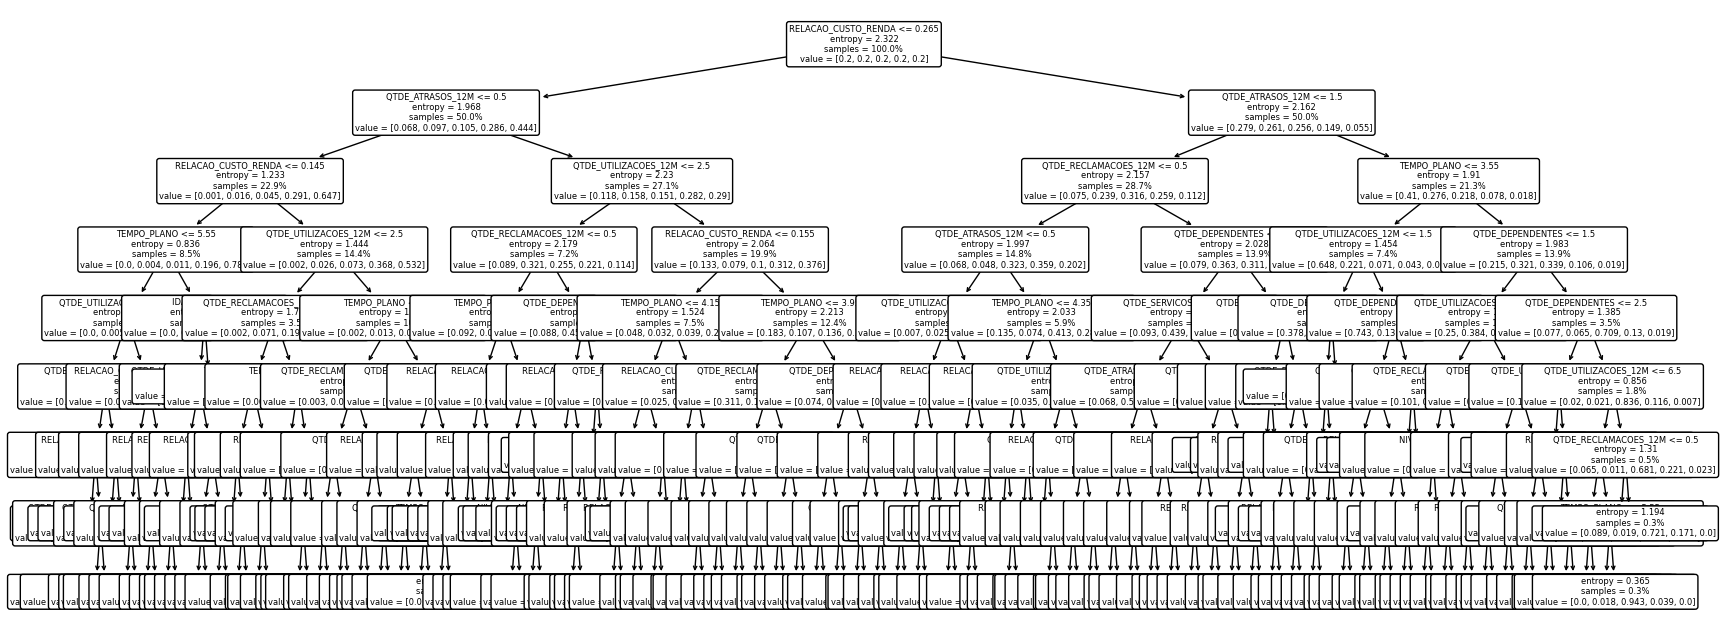

In [29]:
# Visualização da árvore de decisão correspondente ao melhor modelo (em 100% da base de dados) - VISUALMENTE INVIÁVEL
plt.figure(figsize = (20, 8))
tree.plot_tree(arvore_2,
               feature_names = X.columns,
               fontsize = 6,
               rounded = True,
               proportion = True)
plt.show()

### Estimativa de desempenho do modelo 1 em dados totalmente apartados, via validação cruzada estratificada aninhada

In [ ]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'criterion': ['gini', 'entropy'],
    'min_impurity_decrease': [0.0, 0.01, 0.05, 0.1],
    'min_samples_leaf': [100, 200, 500, 1000],
    'max_depth': [2, 3, 5, 10]
}

In [ ]:
# Validação cruzada estratificada aninhada com grid search e otimização de AUC-OVR, k1 = 2 e k2 = 5 (EXECUÇÃO ONEROSA)
arvore = tree.DecisionTreeClassifier(class_weight = "balanced", random_state = 123)
inner_cv = StratifiedKFold(n_splits = 2, shuffle = True, random_state = 123)
outer_cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 123)

scoring = {'AUC_OVR': 'roc_auc_ovr', 'balanced_accuracy': 'balanced_accuracy'}
grid_search = GridSearchCV(arvore, param_grid, cv = inner_cv, scoring = scoring, refit = 'AUC_OVR')
nested_scores = cross_validate(grid_search, X = X, y = y, cv = outer_cv, scoring = scoring)

In [ ]:
# AUC-OVR das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC-OVR), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_AUC_OVR'].round(3))
print("Média de AUC-OVR: " + str(round(np.mean(nested_scores['test_AUC_OVR']), 3)))
print("D.P. de AUC-OVR: " + str(round(np.std(nested_scores['test_AUC_OVR']), 3)))

[0.839 0.838 0.841 0.834 0.837]
Média de AUC-OVR: 0.838
D.P. de AUC-OVR: 0.002


In [ ]:
# Acurácia balanceada das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC-OVR), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_balanced_accuracy'].round(3))
print("Média de Acurácia Balanceada: " + str(round(np.mean(nested_scores['test_balanced_accuracy']), 3)))
print("D.P. de Acurácia Balanceada: " + str(round(np.std(nested_scores['test_balanced_accuracy']), 3)))

[0.606 0.61  0.609 0.591 0.598]
Média de Acurácia Balanceada: 0.603
D.P. de Acurácia Balanceada: 0.007


### Estimativa de desempenho do modelo 2 em dados totalmente apartados, via validação cruzada estratificada aninhada

In [ ]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'criterion': ['gini', 'entropy'],
    'min_impurity_decrease': np.arange(0, 0.11, 0.01),
    'min_samples_leaf': np.arange(100, 1001),
    'max_depth': np.arange(2, 11),
}

In [ ]:
# Validação cruzada estratificada aninhada com random search e otimização de AUC-OVR, k1 = 2 e k2 = 5 (EXECUÇÃO ONEROSA)
arvore = tree.DecisionTreeClassifier(class_weight = "balanced", random_state = 123)
inner_cv = StratifiedKFold(n_splits = 2, shuffle = True, random_state = 123)
outer_cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 123)

scoring = {'AUC_OVR': 'roc_auc_ovr', 'balanced_accuracy': 'balanced_accuracy'}
random_search = RandomizedSearchCV(arvore, param_grid, cv = inner_cv, scoring = scoring, refit = 'AUC_OVR', n_iter = 100, random_state = 123)
nested_scores = cross_validate(random_search, X = X, y = y, cv = outer_cv, scoring = scoring)

In [ ]:
# AUC das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC-OVR), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_AUC_OVR'].round(3))
print("Média de AUC-OVR: " + str(round(np.mean(nested_scores['test_AUC_OVR']), 3)))
print("D.P. de AUC-OVR: " + str(round(np.std(nested_scores['test_AUC_OVR']), 3)))

[0.833 0.834 0.835 0.83  0.831]
Média de AUC-OVR: 0.833
D.P. de AUC-OVR: 0.002


In [ ]:
# Acurácia balanceada das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC-OVR), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_balanced_accuracy'].round(3))
print("Média de Acurácia Balanceada: " + str(round(np.mean(nested_scores['test_balanced_accuracy']), 3)))
print("D.P. de Acurácia Balanceada: " + str(round(np.std(nested_scores['test_balanced_accuracy']), 3)))

[0.594 0.595 0.597 0.587 0.58 ]
Média de Acurácia Balanceada: 0.591
D.P. de Acurácia Balanceada: 0.006


### Aplicação do modelo final de árvore de decisão na base de dados



In [ ]:
# Atribuição das probabilidades preditas por categoria
y_prob = pd.DataFrame(arvore_1.predict_proba(X)[:,:], columns = arvore_1.classes_)
dados_plano = pd.concat([dados_plano, y_prob], axis = 1)

In [ ]:
# Atribuição da categoria predita
dados_plano['y_pred'] = arvore_1.predict(X)

In [ ]:
# Matriz de classificação absoluta: observado versus predito
pd.crosstab(dados_plano['STATUS'], dados_plano['y_pred'], rownames = ['Observado'], colnames = ['Predito'])

Predito,CancInvol,CancVol,Down,Mantem,Up
Observado,,,,,
CancInvol,4395,773,450,249,133
CancVol,569,2714,467,203,47
Down,860,1451,5729,1601,359
Mantem,5085,4885,11342,28255,17433
Up,462,243,304,2098,9893


In [ ]:
# Matriz de classificação relativa: observado versus predito
pd.crosstab(dados_plano['STATUS'], dados_plano['y_pred'], rownames = ['Observado'], colnames = ['Predito'], normalize = 'index').round(2)

Predito,CancInvol,CancVol,Down,Mantem,Up
Observado,,,,,
CancInvol,0.73,0.13,0.08,0.04,0.02
CancVol,0.14,0.68,0.12,0.05,0.01
Down,0.09,0.15,0.57,0.16,0.04
Mantem,0.08,0.07,0.17,0.42,0.26
Up,0.04,0.02,0.02,0.16,0.76


### Importância das features do modelo final

In [30]:
# Cálculo de medida de importância de Gini
importancias = arvore_1.feature_importances_
features = X.columns

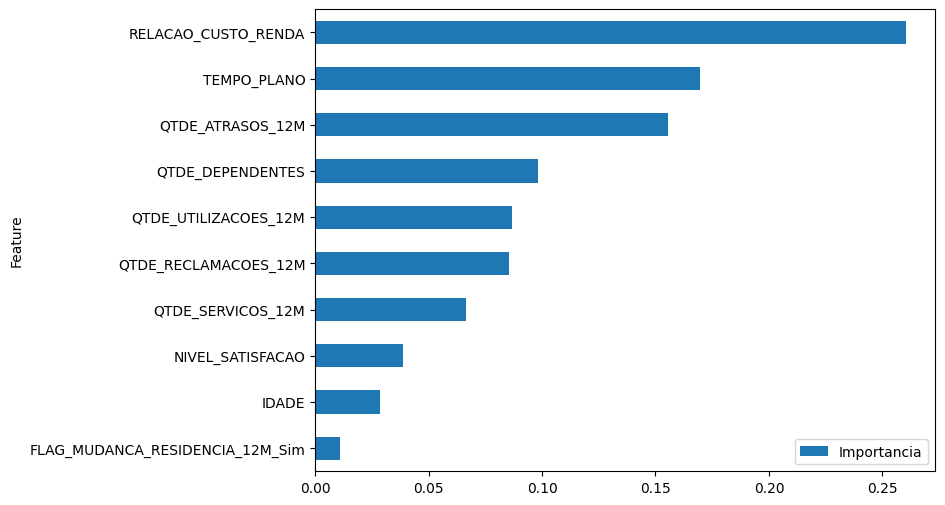

In [31]:
# Gráfico das importâncias de Gini
df_importancias = pd.DataFrame({'Feature': features, 'Importancia': importancias}).sort_values(by = 'Importancia', ascending = True)
df_importancias.plot.barh(x = 'Feature', y = 'Importancia', figsize = (8, 6))
plt.show()

In [34]:
# Cálculo de valores SHAP para as observações
explainer = shap.Explainer(arvore_2)
valores_shap = explainer(X)

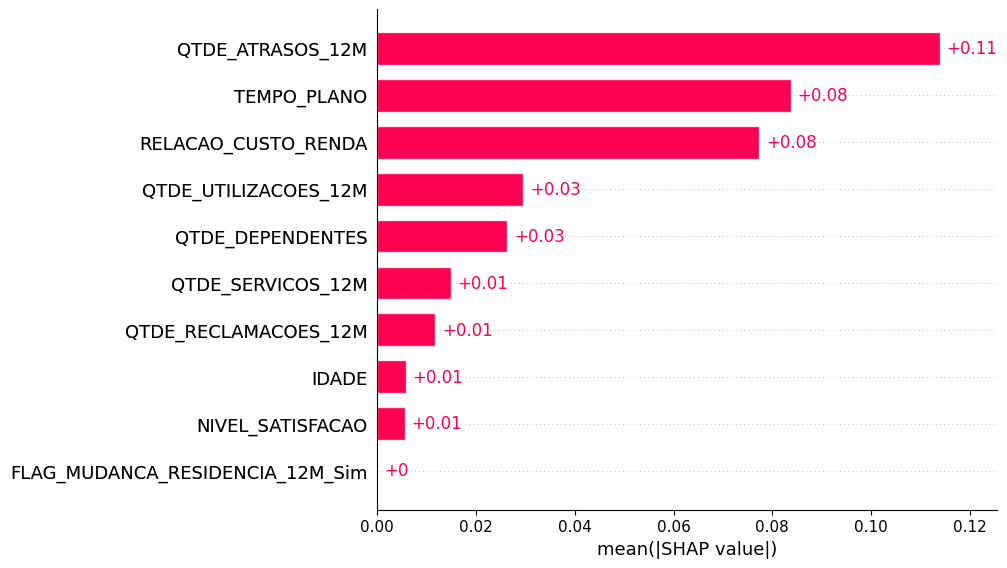

In [37]:
# Gráfico do SHAP absoluto médio por feature: categoria 'CancInvol'
shap.plots.bar(valores_shap[:,:,0])

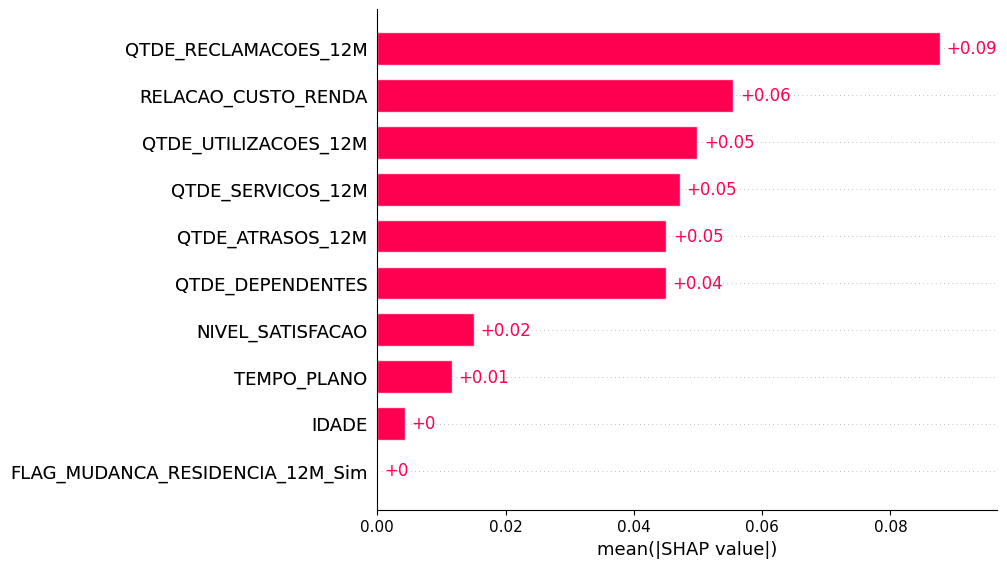

In [ ]:
# Gráfico do SHAP absoluto médio por feature: categoria 'CancVol'
shap.plots.bar(valores_shap[:,:,1])

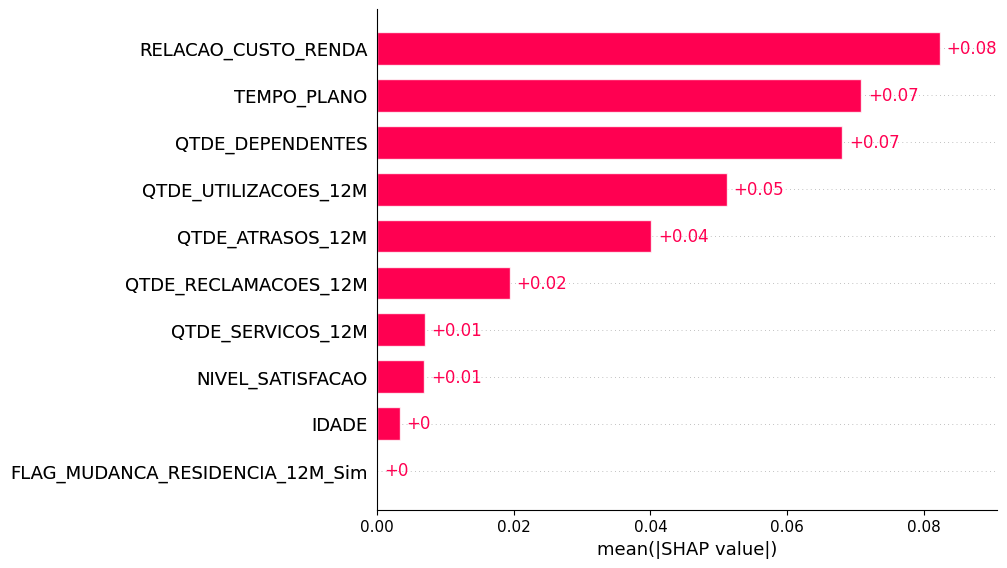

In [ ]:
# Gráfico do SHAP absoluto médio por feature: categoria 'Down'
shap.plots.bar(valores_shap[:,:,2])

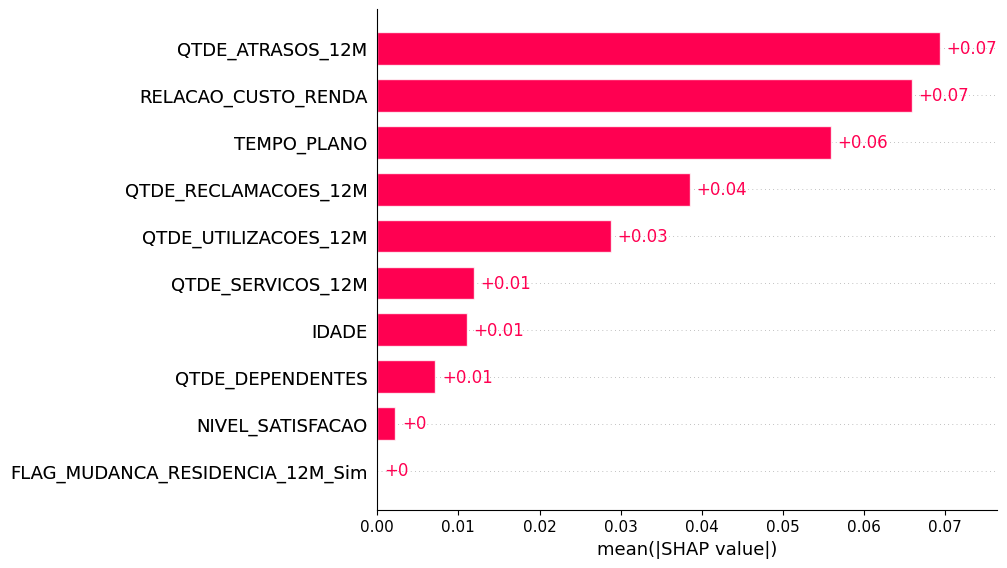

In [ ]:
# Gráfico do SHAP absoluto médio por feature: categoria 'Mantem'
shap.plots.bar(valores_shap[:,:,3])

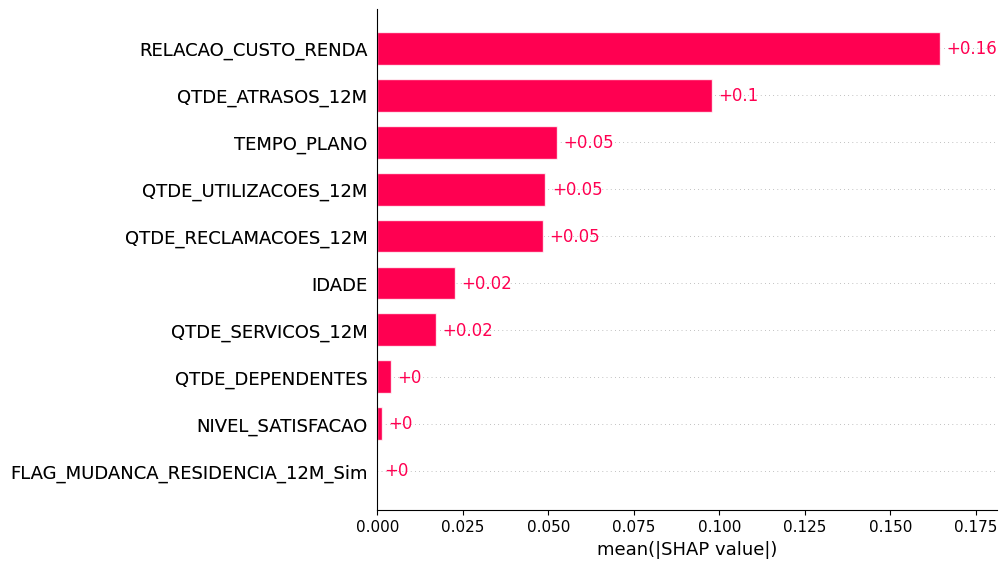

In [ ]:
# Gráfico do SHAP absoluto médio por feature: categoria 'Up'
shap.plots.bar(valores_shap[:,:,4])

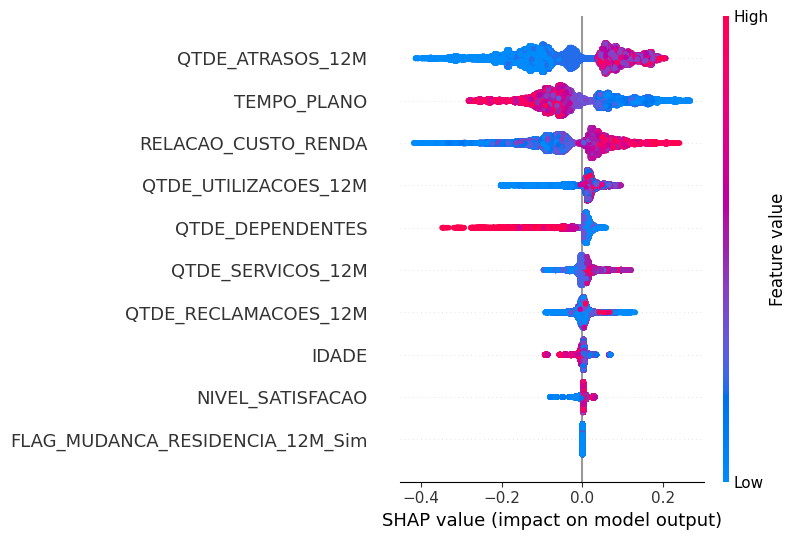

In [ ]:
# Gráfico de distribuição de valores SHAP por feature: "enxame de abelhas" (beeswarm plot): categoria 'CancInvol'
shap.summary_plot(valores_shap[:,:,0])

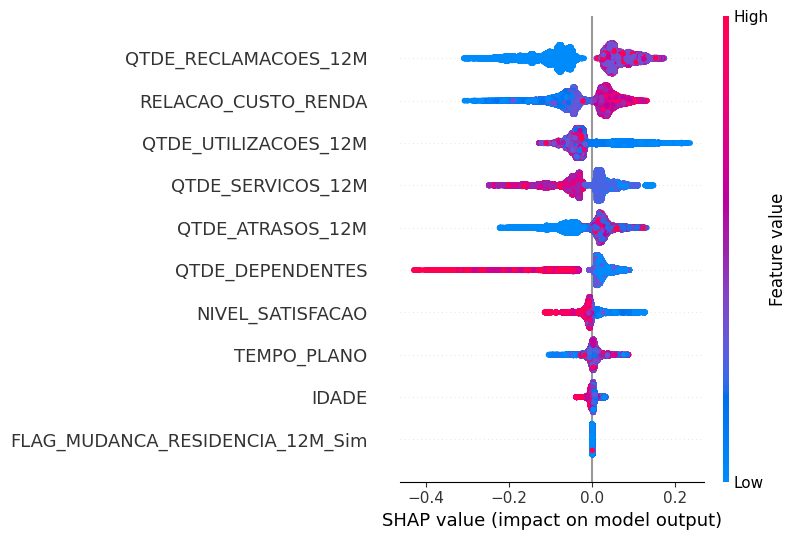

In [ ]:
# Gráfico de distribuição de valores SHAP por feature: "enxame de abelhas" (beeswarm plot): categoria 'CancVol'
shap.summary_plot(valores_shap[:,:,1])

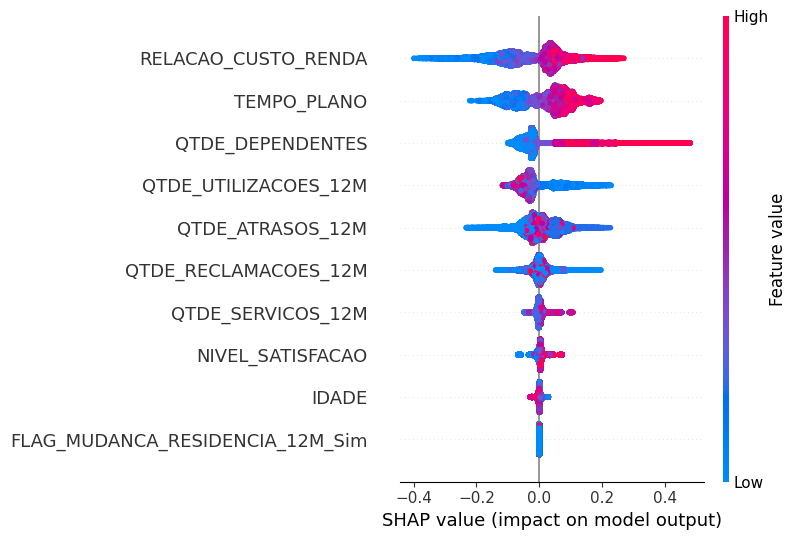

In [ ]:
# Gráfico de distribuição de valores SHAP por feature: "enxame de abelhas" (beeswarm plot): categoria 'Down'
shap.summary_plot(valores_shap[:,:,2])

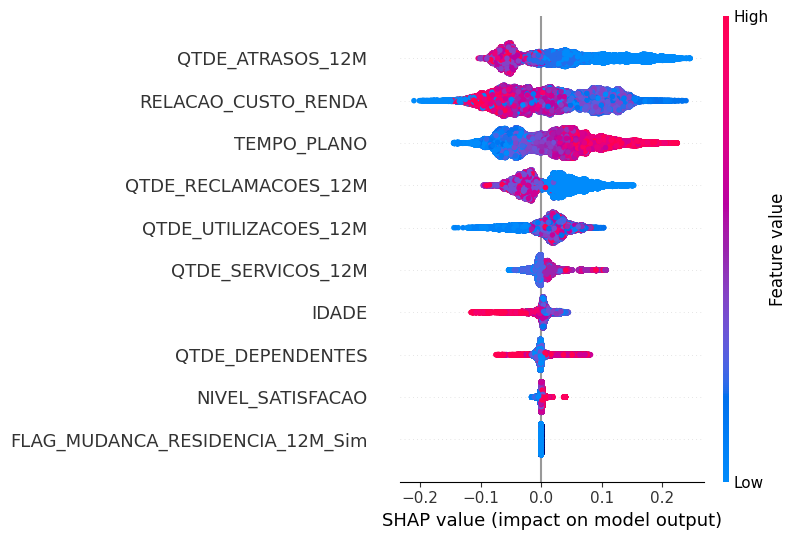

In [ ]:
# Gráfico de distribuição de valores SHAP por feature: "enxame de abelhas" (beeswarm plot): categoria 'Mantem'
shap.summary_plot(valores_shap[:,:,3])

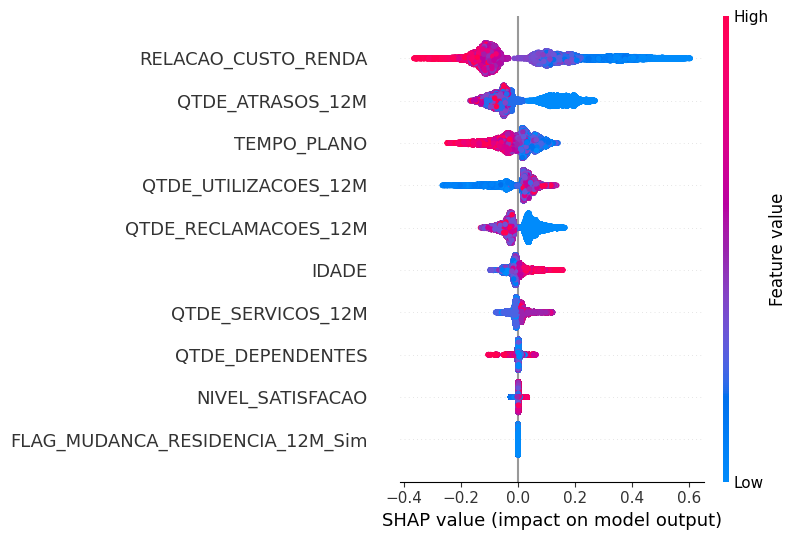

In [ ]:
# Gráfico de distribuição de valores SHAP por feature: "enxame de abelhas" (beeswarm plot): categoria 'Up'
shap.summary_plot(valores_shap[:,:,4])